https://www.kaggle.com/datasets/debeshjha1/kvasircapsuleseg

Итоговое задание - выполнить сегментацию полипов согласно приложенного датасета.

1. подготовить данные должным образом.
2. Попробовать различные архитектуры, выбрать наилучшую.
3. Попробовать аугментацию, трансферное обучение.
4. Визуализировать предсказания выбранной модели.
5. Составить обобщающий хороший вывод.
6. (по желанию) сделать API


https://habr.com/ru/companies/otus/articles/442918/ - как делать API для ML

Сдавать как обычно Гитхаб или Гугл колаб.


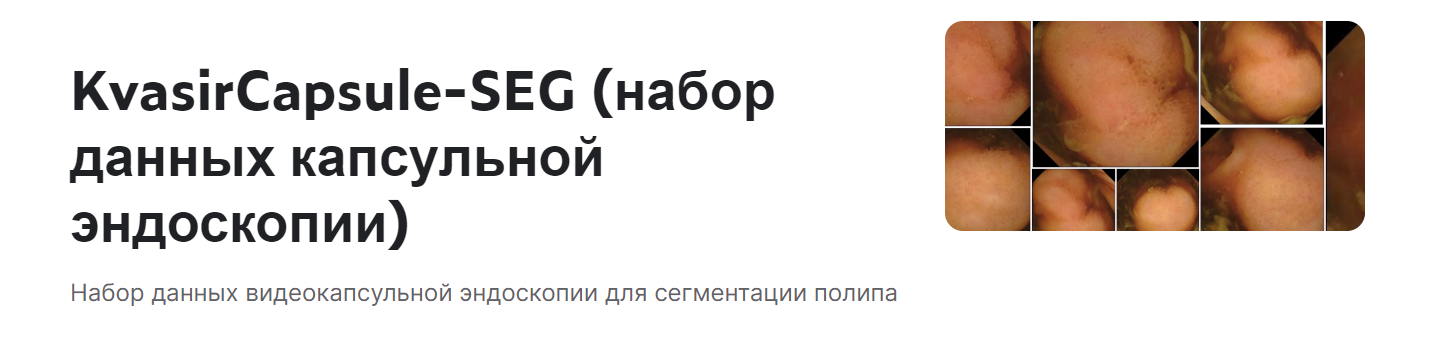

"О наборе данных

Подробная информация о наборе данных

KvasirCapsule-SEG - это расширенное подмножество Kvasir-Capsule, которое содержит изображения полипов, достоверность их сегментации и ограничивающую информацию. Класс полипов Kvasir-Capsule содержит всего 55 изображений, которые мы прокомментировали с помощью опытного гастроэнтеролога."

# Загрузка данных и библиотек

In [ ]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !kaggle datasets list

In [ ]:
# !kaggle datasets download -d debeshjha1/kvasircapsuleseg

In [ ]:
# !ls

In [ ]:
# !unzip /content/kvasircapsuleseg.zip -d /content/drive/MyDrive/

In [ ]:
!pip install --quiet segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 54.3 MB/s eta 0:00:00


In [ ]:
from collections import defaultdict
import copy
import random
import os
import segmentation_models_pytorch.utils as smp_utils
from segmentation_models_pytorch import Linknet

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader

# SegNet

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.Sigmoid()
            )
    def forward(self, x):
        # encoder
        e0, indices_e0 = self.pool0(self.enc_conv0(x))
        e1, indices_e1 = self.pool1(self.enc_conv1(e0))
        e2, indices_e2 = self.pool2(self.enc_conv2(e1))
        e3, indices_e3 = self.pool3(self.enc_conv3(e2))
        # bottleneck
        b = self.bottleneck_conv(e3)
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, indices_e3))
        d1 = self.dec_conv1(self.upsample1(d0, indices_e2))
        d2 = self.dec_conv2(self.upsample2(d1, indices_e1))
        d3 = self.dec_conv3(self.upsample3(d2, indices_e0))
        return d3

#UNet

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)# 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
            nn.Sigmoid()
            )
    def forward(self, x):
        # encoder
        enc0 = self.enc_conv0(x)
        pool0, indices_e0 = self.pool0(enc0)
        enc1 = self.enc_conv1(pool0)
        pool1, indices_e1 = self.pool1(enc1)
        enc2 = self.enc_conv2(pool1)
        pool2, indices_e2 = self.pool2(enc2)
        enc3 = self.enc_conv3(pool2)
        pool3, indices_e3 = self.pool3(enc3)
        # bottleneck
        b = self.bottleneck_conv(pool3)
        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b, indices_e3), enc3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0, indices_e2), enc2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1, indices_e1), enc1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2, indices_e0), enc0), dim=1))
        # no activation
        return d3

# Разделение на тренировочную, валидационную и тестовую выборки

In [ ]:
root_directory = os.path.join('/content/drive/MyDrive/Kvasir-Capsule/')
images_directory = os.path.join(root_directory, 'images')
masks_directory = os.path.join(root_directory, 'masks')

images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:40]
val_images_filenames = correct_images_filenames[40:-5]
test_images_filenames = images_filenames[-5:]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

40 10 5


# Функция для визуализации датасета и предсказаний

In [ ]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename), cv2.IMREAD_UNCHANGED,)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask.squeeze(), interpolation="nearest", cmap='gray')
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

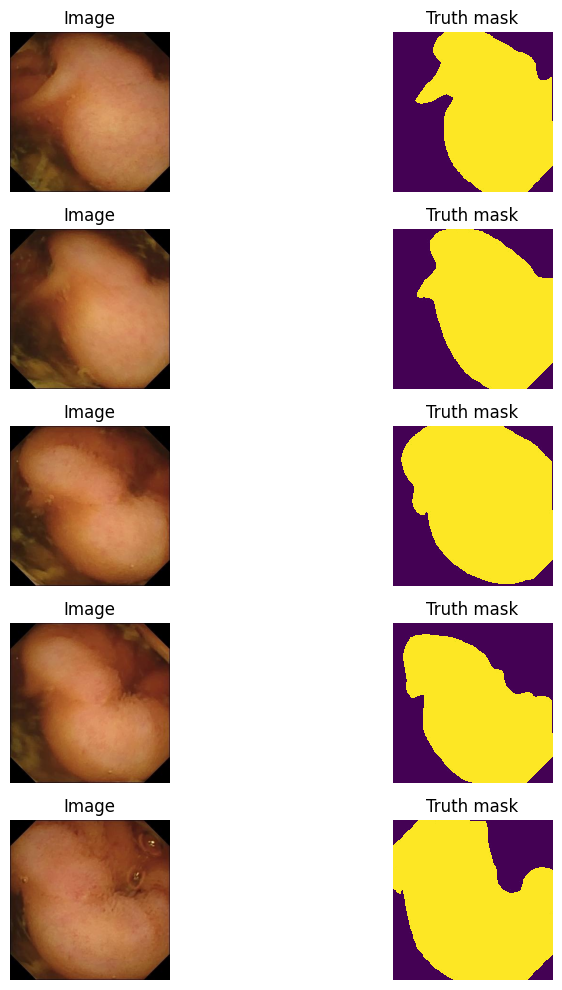

In [ ]:
display_image_grid(test_images_filenames, images_directory, masks_directory)

# Загрузка, подготовка и аугментация данных

In [ ]:
class KvasirCapsuleSEG(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename), cv2.IMREAD_UNCHANGED,
        )
        # mask = preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"] / 255
            mask = transformed["mask"] / 255

        return image, mask

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        ToTensorV2(),
    ]
)
train_dataset = KvasirCapsuleSEG(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [A.Resize(256, 256),
     ToTensorV2()]
)
val_dataset = KvasirCapsuleSEG(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

In [ ]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0.

## Визуализация аугментации

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(13, 13))
    for i in range(samples):
        image, mask = next(iter(dataset)) # dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

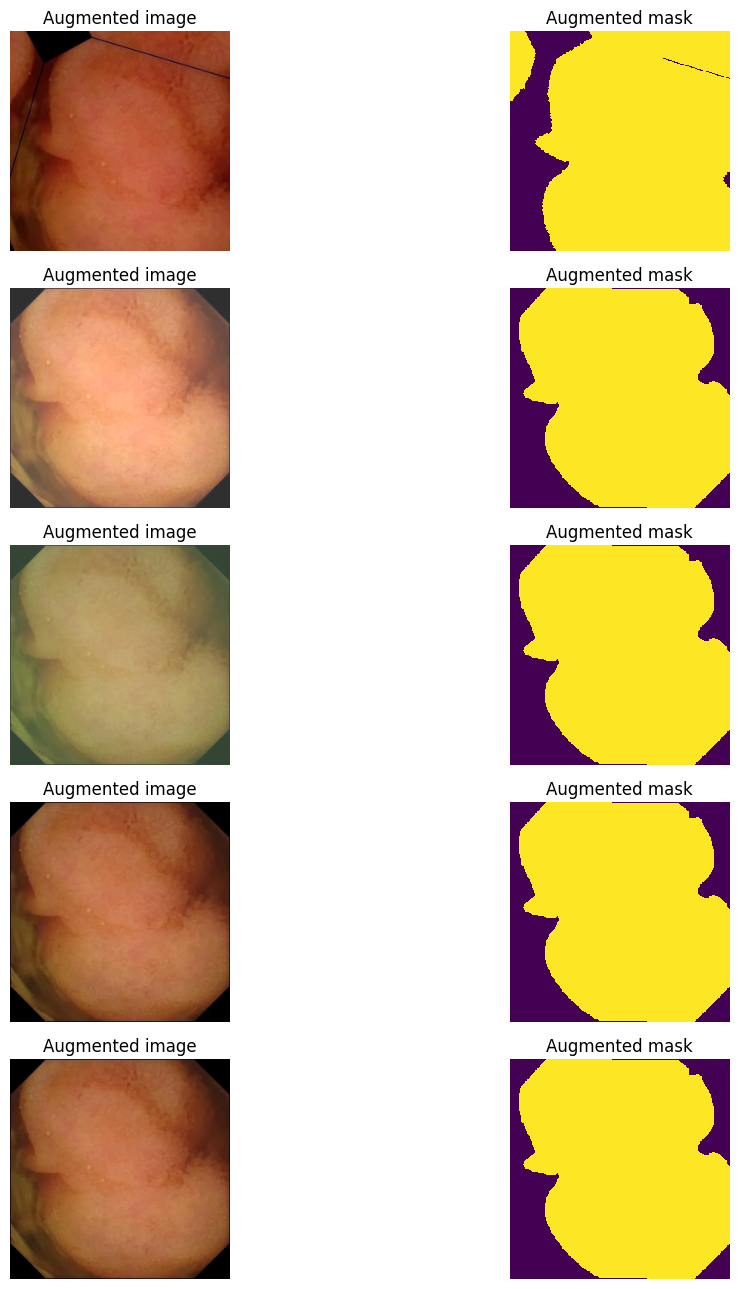

In [ ]:
random.seed(42)
visualize_augmentations(train_dataset, idx=0)

# Вспомогательные функции

## Мониторинг метрики и фукции потерь

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

## Для обучения

In [ ]:
def train(train_loader, model, criterion, metric, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images
        target = target.float()
        output = model(images).squeeze(1).float()
        loss = criterion(output, target)
        iou = metric(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("IOU", iou.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

## Для валидации

In [ ]:
def validate(val_loader, model, criterion, metric, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images
            target = target.float()
            output = model(images).squeeze(1).float()
            iou = metric(output, target)
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("IOU", iou.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

## Для компиляции модели

In [ ]:
def train_and_validate(model, train_dataset, val_dataset, params):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
    )
    metric = smp_utils.metrics.IoU()
    criterion = smp_utils.losses.DiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, metric, optimizer, epoch, params)
        validate(val_loader, model, criterion, metric, epoch, params)
    return model

## Для предсказания

In [ ]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = probabilities.float() #(probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions

# Обучение

In [ ]:
params = {
    "lr": 0.001,
    "batch_size": 4,
    "epochs": 10,
}

## UNet

In [ ]:
u_model = UNet()
u_model = train_and_validate(u_model, train_dataset, val_dataset, params)

Epoch: 1. Train. Loss: 0.288 | IOU: 0.639: 100%|██████████| 10/10 [03:56<00:00, 23.65s/it]
Epoch: 1. Validation. Loss: 0.266 | IOU: 0.674: 100%|██████████| 3/3 [00:15<00:00,  5.29s/it]
Epoch: 2. Train. Loss: 0.183 | IOU: 0.798: 100%|██████████| 10/10 [04:00<00:00, 24.05s/it]
Epoch: 2. Validation. Loss: 0.200 | IOU: 0.761: 100%|██████████| 3/3 [00:16<00:00,  5.48s/it]
Epoch: 3. Train. Loss: 0.164 | IOU: 0.803: 100%|██████████| 10/10 [04:04<00:00, 24.41s/it]
Epoch: 3. Validation. Loss: 0.146 | IOU: 0.834: 100%|██████████| 3/3 [00:15<00:00,  5.25s/it]
Epoch: 4. Train. Loss: 0.163 | IOU: 0.786: 100%|██████████| 10/10 [04:42<00:00, 28.21s/it]
Epoch: 4. Validation. Loss: 0.127 | IOU: 0.837: 100%|██████████| 3/3 [00:16<00:00,  5.50s/it]
Epoch: 5. Train. Loss: 0.175 | IOU: 0.758: 100%|██████████| 10/10 [04:04<00:00, 24.47s/it]
Epoch: 5. Validation. Loss: 0.131 | IOU: 0.833: 100%|██████████| 3/3 [00:16<00:00,  5.42s/it]
Epoch: 6. Train. Loss: 0.145 | IOU: 0.796: 100%|██████████| 10/10 [04:10<00

## SegNet

In [ ]:
sn_model = SegNet()
sn_model = train_and_validate(sn_model, train_dataset, val_dataset, params)

Epoch: 1. Train. Loss: 0.328 | IOU: 0.588: 100%|██████████| 10/10 [03:53<00:00, 23.39s/it]
Epoch: 1. Validation. Loss: 0.333 | IOU: 0.633: 100%|██████████| 3/3 [00:16<00:00,  5.33s/it]
Epoch: 2. Train. Loss: 0.240 | IOU: 0.606: 100%|██████████| 10/10 [03:37<00:00, 21.79s/it]
Epoch: 2. Validation. Loss: 0.204 | IOU: 0.642: 100%|██████████| 3/3 [00:14<00:00,  4.92s/it]
Epoch: 3. Train. Loss: 0.206 | IOU: 0.690: 100%|██████████| 10/10 [04:07<00:00, 24.70s/it]
Epoch: 3. Validation. Loss: 0.145 | IOU: 0.788: 100%|██████████| 3/3 [00:20<00:00,  6.97s/it]
Epoch: 4. Train. Loss: 0.169 | IOU: 0.762: 100%|██████████| 10/10 [04:39<00:00, 27.91s/it]
Epoch: 4. Validation. Loss: 0.116 | IOU: 0.812: 100%|██████████| 3/3 [00:14<00:00,  4.95s/it]
Epoch: 5. Train. Loss: 0.142 | IOU: 0.781: 100%|██████████| 10/10 [04:12<00:00, 25.27s/it]
Epoch: 5. Validation. Loss: 0.117 | IOU: 0.804: 100%|██████████| 3/3 [00:15<00:00,  5.08s/it]
Epoch: 6. Train. Loss: 0.131 | IOU: 0.780: 100%|██████████| 10/10 [04:22<00

## Трансферное обучение c ResNet50

In [ ]:
res_model = Linknet(encoder_name='resnet50',
               encoder_weights='imagenet',
               classes=1,
               activation='sigmoid')
res_model = train_and_validate(res_model, train_dataset, val_dataset, params)

Epoch: 1. Train. Loss: 0.321 | IOU: 0.663: 100%|██████████| 10/10 [01:21<00:00,  8.15s/it]
Epoch: 1. Validation. Loss: 0.371 | IOU: 0.662: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]
Epoch: 2. Train. Loss: 0.196 | IOU: 0.796: 100%|██████████| 10/10 [01:00<00:00,  6.07s/it]
Epoch: 2. Validation. Loss: 0.205 | IOU: 0.734: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]
Epoch: 3. Train. Loss: 0.143 | IOU: 0.845: 100%|██████████| 10/10 [00:57<00:00,  5.76s/it]
Epoch: 3. Validation. Loss: 0.177 | IOU: 0.752: 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]
Epoch: 4. Train. Loss: 0.126 | IOU: 0.854: 100%|██████████| 10/10 [01:12<00:00,  7.20s/it]
Epoch: 4. Validation. Loss: 0.122 | IOU: 0.819: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]
Epoch: 5. Train. Loss: 0.120 | IOU: 0.845: 100%|██████████| 10/10 [01:07<00:00,  6.76s/it]
Epoch: 5. Validation. Loss: 0.115 | IOU: 0.823: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]
Epoch: 6. Train. Loss: 0.110 | IOU: 0.849: 100%|██████████| 10/10 [00:58<00

# Работа нейросети на тесте

## Загрузка и преобразование тестового датасета

In [ ]:
class KvasirCapsuleSEGInference(Dataset):
    def __init__(self, images_filenames, images_directory
                 #, masks_directory
                 , transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        #self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        #mask = cv2.imread(
            #os.path.join(self.masks_directory, image_filename),
            #cv2.IMREAD_UNCHANGED)
        if self.transform is not None:
            transformed = self.transform(image=image
                                         #, mask=mask
                                         )
            image = transformed["image"] / 255
            #mask = transformed["mask"] / 255

        return image, original_size #, mask

In [ ]:
test_transform = A.Compose(
    [A.Resize(256, 256), ToTensorV2()]
)
test_dataset = KvasirCapsuleSEGInference(test_images_filenames, images_directory, transform=test_transform,) # masks_directory,

In [ ]:
test_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 (336, 336))

## Предсказание

## Визуализация результатов

### SegNet

In [ ]:
predictions = predict(sn_model, params, test_dataset, batch_size=1)

In [ ]:
predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    full_sized_mask = A.resize(
        predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )
    predicted_masks.append(full_sized_mask)

In [ ]:
predictions[0]

(array([[0.5263894 , 0.5090095 , 0.50552773, ..., 0.5100016 , 0.51684505,
         0.549573  ],
        [0.507296  , 0.5009752 , 0.5003627 , ..., 0.5011089 , 0.5025635 ,
         0.5174006 ],
        [0.5034587 , 0.5002605 , 0.50008786, ..., 0.5003539 , 0.5010294 ,
         0.5097977 ],
        ...,
        [0.5054911 , 0.5005824 , 0.5001598 , ..., 0.50069433, 0.5019516 ,
         0.51465017],
        [0.50969076, 0.5011003 , 0.50040996, ..., 0.5015302 , 0.5041513 ,
         0.52019376],
        [0.53372806, 0.50924563, 0.5052539 , ..., 0.5108591 , 0.51801217,
         0.5443439 ]], dtype=float32),
 336,
 336)

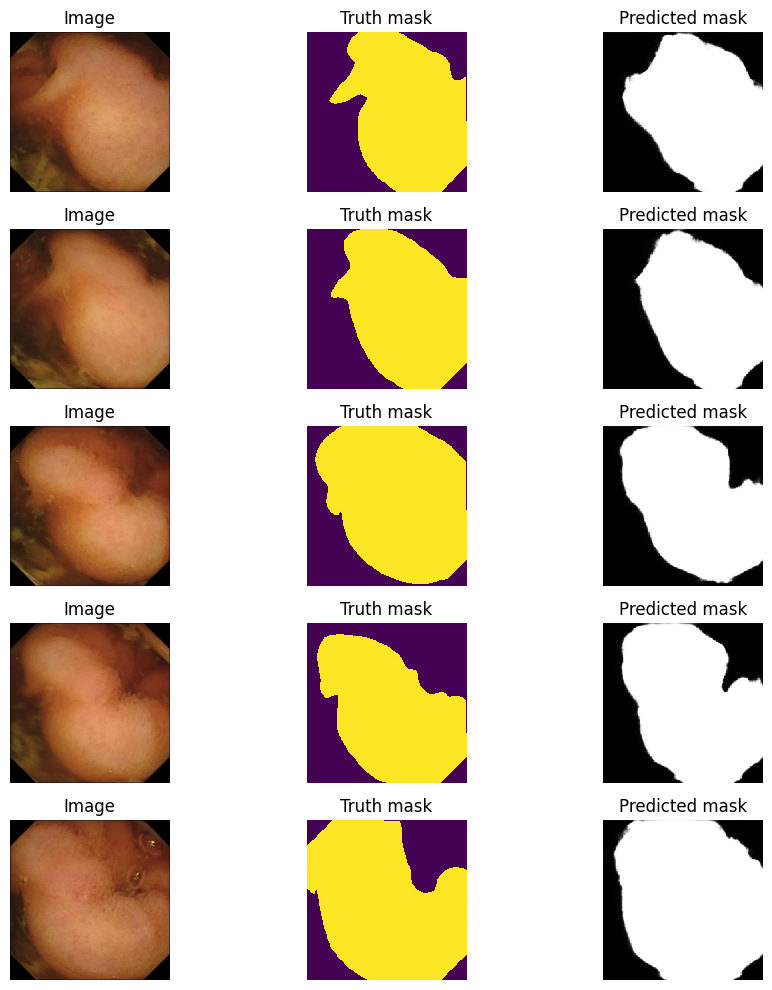

In [ ]:
display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)

### UNet

In [ ]:
predictions = predict(u_model, params, test_dataset, batch_size=1)

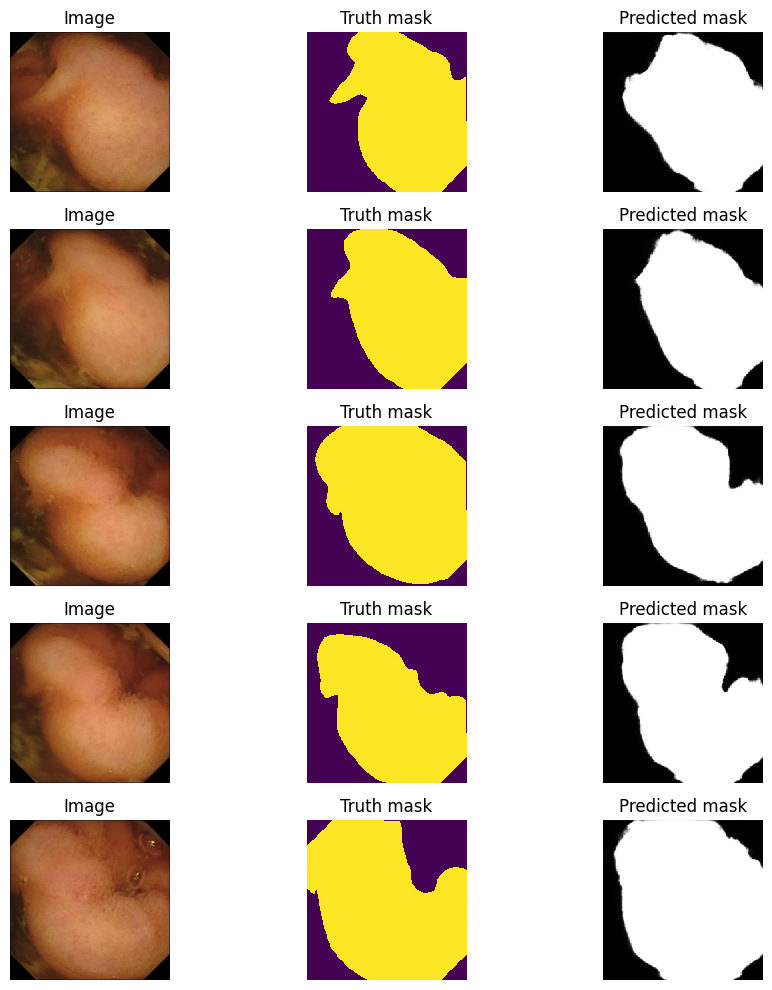

In [ ]:
display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)

### ResNet

In [ ]:
predictions = predict(res_model, params, test_dataset, batch_size=1)

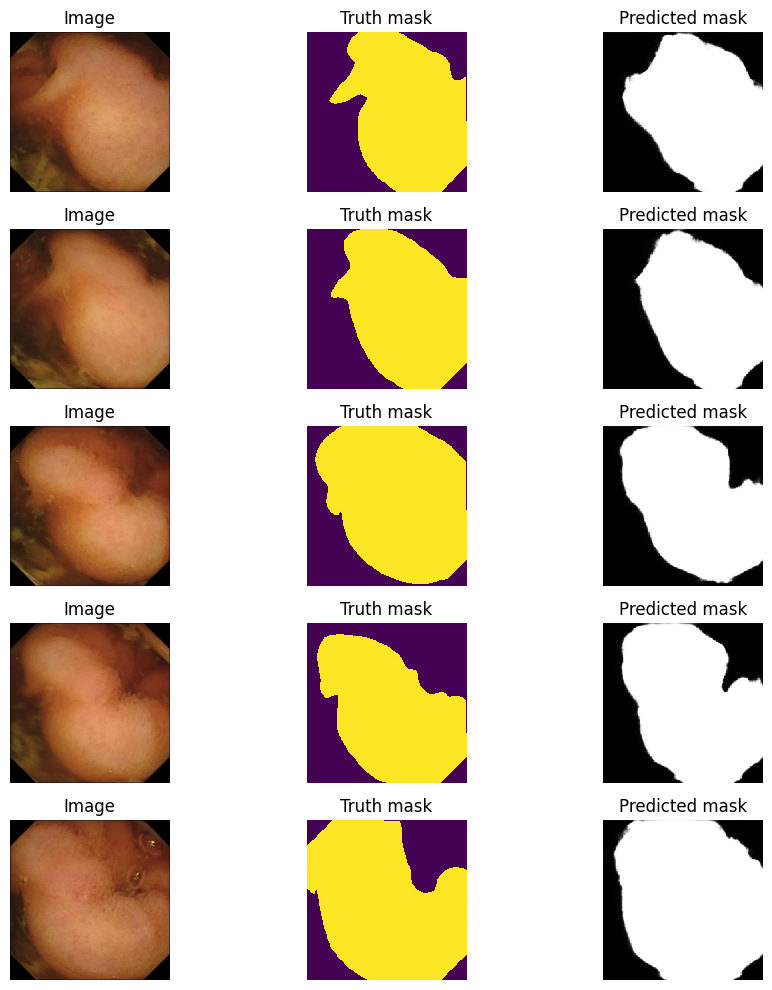

In [ ]:
display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)

# Выводы:
1. Все три нейросети неплохо предсказывают полипы. Качество сравнимое. Лучшая нейросеть по метрикам - претренированная ResNet50.
2. Разметка масок сделана не очень хорошо.
3. Маленький размер датасета. Аугментация частично спасает.
4. Большее количество эпох может улучшить качество нейросетей. Но в самописные нейросети при этом необходимо добавить слои Dropout, чтобы избежать переобучения.